# Logistic Regression

Logistic Regression is used as a simple and interpretable baseline model to estimate the probability that a vehicle service can be justified, based on a combination of features including the service price, vehicle make, model, year, and vehicle category.

In this project, Logistic Regression models the probability of a justified service by fitting a logistic function to a linear combination of the input features:


## Logistic Regression Significance
- Interpretability: 
    - Coefficients indicate how each feature (price, make, model, year, category) influences the likelihood of service justification.
- Confidence Scores: 
    - Outputs a probability between 0 and 1, offering a calibrated confidence score for decision-making.
- Baseline Benchmark: 
    - Serves as a simple benchmark to compare against more complex models.
- Efficiency: 
    - Fast and scalable even with multiple categorical and numerical features.

## Important Considerations for the Design of the Model
- Handling Categorical Features: 
    - Vehicle make, model, and category must be encoded (e.g., via one-hot encoding or target encoding) to be usable by the model.
- Feature Scaling: 
    - Although Logistic Regression does not strictly require feature scaling, scaling numeric features like price and year can improve model stability.
- Linear Assumption: 
    - Assumes a linear relationship between the features and the log-odds of the outcome, which may be an oversimplification.
- Sensitivity to Outliers: 
    - Outliers, particularly in service price or vehicle year, could affect model performance.

---





In [75]:
# Preprocessing of Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [76]:
df = pd.read_csv('../data/data.csv')
cpi = pd.read_csv('../data/cpi.csv')

# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

merged_df = df.merge(cpi, on='Quarter');
merged_df['adjusted_price'] = merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI'])

merged_df.drop(columns=['BookingID', 'BTicketID', 'IsCustomService', 'IsCustomRepair', 'BShopID', 'BShopPostcode', 'BShopState', 'BShopRegionName', 'BShopRegionClass', 'VYMM'], inplace=True)

merged_df.head()

C:\Users\jackl\AppData\Local\Temp\ipykernel_39236\3784073025.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
C:\Users\jackl\AppData\Local\Temp\ipykernel_39236\3784073025.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


,FCID,BCreatedDateAEST,BTicketType,TaskName,PriceIncGSTRaw,VMakeModel,VMake,VYear,Quarter,CPI,adjusted_price
0,1,2021-06-17,Capped,Capped Price - 30K,180.00,TOYOTA COROLLA,TOYOTA,2019,2021Q2,118.8,211.212121
1,2,2024-01-11,Capped,Capped Price - 50K,315.90,MAZDA CX-5,MAZDA,2021,2024Q1,137.4,320.498253
2,1,2022-10-19,Repair,Replace Wiper Blades,120.00,SKODA KAROQ,SKODA,2020,2022Q4,130.8,127.889908
3,2,2022-11-11,Logbook,Logbook - 60K / 48m,462.10,MITSUBISHI ASX,MITSUBISHI,2018,2022Q4,130.8,492.482722
4,2,2024-07-30,Capped,Capped Price - 30K,359.21,MAZDA 3,MAZDA,2020,2024Q3,139.1,359.984716


In [77]:
# Calculate the median price for each combination of TaskName, VMakeModel, and VYear
median_prices = merged_df.groupby(['TaskName', 'VMakeModel', 'VYear'])['adjusted_price'].median().reset_index()
median_prices = median_prices.rename(columns={'adjusted_price': 'MedianPrice'})

# Merge the median prices back with the original merged_df
merged_df = pd.merge(merged_df, median_prices, on=['TaskName', 'VMakeModel', 'VYear'], how='left')


# Justified if the price is within 10% of the median price for that task, make/model, and year
lower_bound = merged_df['MedianPrice'] * 0.90
upper_bound = merged_df['MedianPrice'] * 1.10

# Create the "Justified" column
merged_df['Justified'] = ((merged_df['adjusted_price'] >= lower_bound) & (merged_df['adjusted_price'] <= upper_bound)).astype(int)

print(merged_df.head())
print(merged_df.shape)

   FCID BCreatedDateAEST BTicketType              TaskName  PriceIncGSTRaw  \
0     1       2021-06-17      Capped    Capped Price - 30K          180.00   
1     2       2024-01-11      Capped    Capped Price - 50K          315.90   
2     1       2022-10-19      Repair  Replace Wiper Blades          120.00   
3     2       2022-11-11     Logbook   Logbook - 60K / 48m          462.10   
4     2       2024-07-30      Capped    Capped Price - 30K          359.21   

       VMakeModel       VMake  VYear Quarter    CPI  adjusted_price  \
0  TOYOTA COROLLA      TOYOTA   2019  2021Q2  118.8      211.212121   
1      MAZDA CX-5       MAZDA   2021  2024Q1  137.4      320.498253   
2     SKODA KAROQ       SKODA   2020  2022Q4  130.8      127.889908   
3  MITSUBISHI ASX  MITSUBISHI   2018  2022Q4  130.8      492.482722   
4         MAZDA 3       MAZDA   2020  2024Q3  139.1      359.984716   

   MedianPrice  Justified  
0   206.912638          1  
1   362.000000          0  
2   119.254286      

In [78]:
# Count number of occurrences per group
group_counts = merged_df.groupby(['TaskName', 'VMakeModel', 'VYear']).size().reset_index(name='Count')

# Keep only groups with at least, say, 5 examples
min_required = 5
valid_groups = group_counts[group_counts['Count'] >= min_required]

# Merge to keep only valid groups in main dataset
merged_df = merged_df.merge(valid_groups[['TaskName', 'VMakeModel', 'VYear']], 
                            on=['TaskName', 'VMakeModel', 'VYear'], 
                            how='inner')
print(merged_df.head())
print(merged_df.shape)

   FCID BCreatedDateAEST BTicketType              TaskName  PriceIncGSTRaw  \
0     1       2021-06-17      Capped    Capped Price - 30K          180.00   
1     2       2024-01-11      Capped    Capped Price - 50K          315.90   
2     1       2022-10-19      Repair  Replace Wiper Blades          120.00   
3     2       2022-11-11     Logbook   Logbook - 60K / 48m          462.10   
4     2       2024-07-30      Capped    Capped Price - 30K          359.21   

       VMakeModel       VMake  VYear Quarter    CPI  adjusted_price  \
0  TOYOTA COROLLA      TOYOTA   2019  2021Q2  118.8      211.212121   
1      MAZDA CX-5       MAZDA   2021  2024Q1  137.4      320.498253   
2     SKODA KAROQ       SKODA   2020  2022Q4  130.8      127.889908   
3  MITSUBISHI ASX  MITSUBISHI   2018  2022Q4  130.8      492.482722   
4         MAZDA 3       MAZDA   2020  2024Q3  139.1      359.984716   

   MedianPrice  Justified  
0   206.912638          1  
1   362.000000          0  
2   119.254286      

In [79]:
# --- Feature and Target Selection ---

# Define input features to be used for prediction
features = ['adjusted_price', 'VMakeModel', 'VYear']

# Define the target variable (label)
target = 'Justified'

# Split the dataset into feature matrix (X) and target vector (y)
X = merged_df[features]
y = merged_df[target]

# --- Train-Test Split ---

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Preprocessing Pipelines ---

# Specify which features are categorical and which are numerical
categorical_features = ['VMakeModel']
numerical_features = ['adjusted_price', 'VYear']

# Create preprocessing transformer for categorical features (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessing transformer for numerical features (standardization)
numerical_transformer = StandardScaler()

# Combine transformers into a single preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  # scale numerical
        ('cat', categorical_transformer, categorical_features)  # encode categorical
    ]
)

# --- Model Pipeline Definition ---

# Create a pipeline that first preprocesses data then fits a logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))  # liblinear is good for small datasets
    # ('classifier', LogisticRegression(solver='saga'))  # Uncomment this line to use saga solver
    # It was not used in the original code as the model did not converge, but it's a good alternative
])


# --- Model Training ---

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# --- Model Evaluation ---

# Print accuracy on training and test sets
print(f"Training Accuracy: {pipeline.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test):.2f}")





Training Accuracy: 0.59
Test Accuracy: 0.59


Training Accuracy: 0.59
Test Accuracy: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55     39158
           1       0.58      0.66      0.61     39834

    accuracy                           0.59     78992
   macro avg       0.59      0.58      0.58     78992
weighted avg       0.59      0.59      0.58     78992



<Figure size 800x600 with 0 Axes>

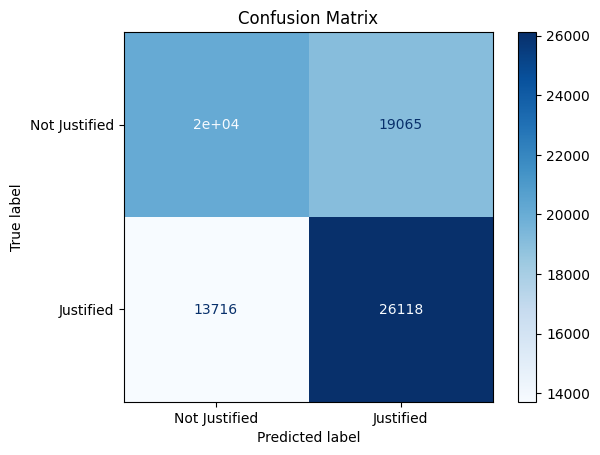

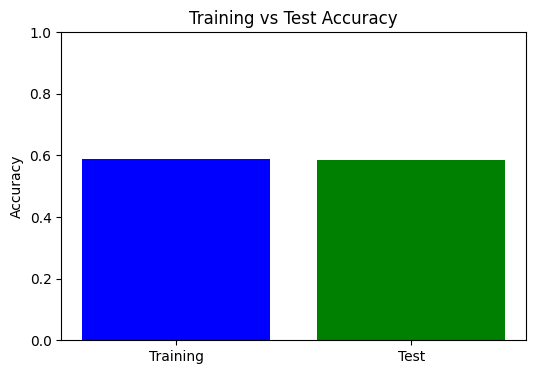

In [80]:

# --- Model Evaluation ---

# Accuracy on training and testing data
train_accuracy = pipeline.score(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)

# Print accuracy on training and test sets
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# --- Detailed Performance Metrics ---
y_pred = pipeline.predict(X_test)

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Justified', 'Justified'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# --- Plotting the accuracy comparison (Training vs Test) ---

# Plot bar chart of training and testing accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.show()

In [81]:
# Define the parameter grid
# param_grid = {
    # 'classifier__C': [0.1, 1, 10, 100],
    # 'classifier__penalty': ['l1', 'l2'],
    # 'classifier__solver': ['liblinear', 'saga']
# }

# Create a GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the grid search
# grid_search.fit(X_train, y_train)

# Print best parameters and best score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Training Accuracy: {grid_search.best_score_:.2f}")

In [82]:
# Predict the class labels and the confidence scores
y_pred = pipeline.predict(X_test)
confidence_scores = pipeline.predict_proba(X_test)[:, 1]

# Create a DataFrame for better visualization
confidence_df = pd.DataFrame({
    'Predicted Class': y_pred,
    'Confidence Score': confidence_scores
})



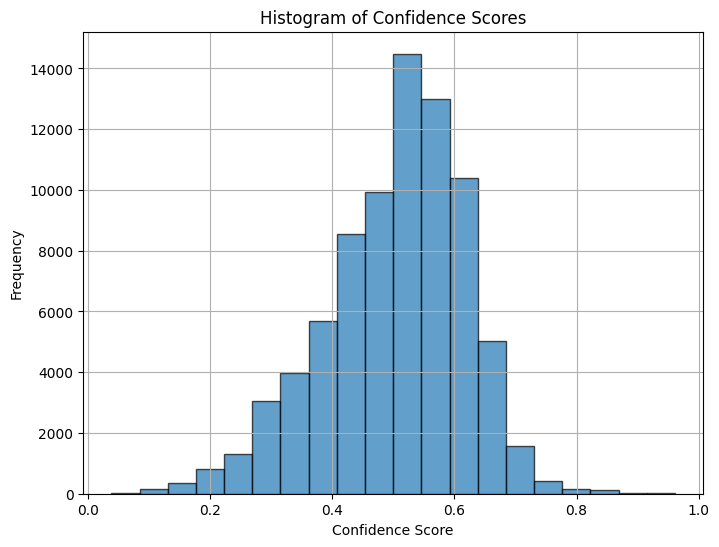

In [83]:
# Plotting histogram of the confidence scores
plt.figure(figsize=(8, 6))
plt.hist(confidence_scores, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [84]:
# Identify incorrect predictions
incorrect_indices = y_pred != y_test

# Calculate the number of incorrect predictions
num_incorrect = incorrect_indices.sum()

# Calculate the number of correct predictions
num_correct = len(y_pred) - num_incorrect

# Display the number of incorrect and correct predictions
print(f"Number of incorrect predictions: {num_incorrect}")
print(f"Number of correct predictions: {num_correct}")

# Use .loc instead of .iloc for boolean indexing to get the incorrect predictions
incorrect_confidence = pd.DataFrame({
    'Actual Class': y_test.loc[incorrect_indices],  # Use .loc here
    'Predicted Class': y_pred[incorrect_indices],
    'Confidence Score': confidence_scores[incorrect_indices]
})

# Display the first few rows of the incorrect predictions
print(incorrect_confidence.head(100))


Number of incorrect predictions: 32781
Number of correct predictions: 46211
        Actual Class  Predicted Class  Confidence Score
285970             0                1          0.543518
56074              0                1          0.506686
25154              1                0          0.477768
242465             0                1          0.543857
310111             0                1          0.544667
...              ...              ...               ...
347121             0                1          0.505416
261340             0                1          0.653840
14463              0                1          0.613528
279338             1                0          0.355768
64586              0                1          0.533834

[100 rows x 3 columns]
